## Setup

In [1]:
import numpy as np
import xarray as xr

import collections
import inspect

import ioos_qc
from ioos_qc.config import Config

from ioos_qc.qartod import aggregate
from ioos_qc.streams import XarrayStream
from ioos_qc.results import collect_results, CollectedResult

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

In [2]:
datadir = '../Example Glider Data/'

In [3]:
pyglider_timeseries = xr.open_dataset(datadir+"TVAR20232.nc")
pyglider_timeseries

<xarray.Dataset>
Dimensions:                (time: 2844)
Coordinates:
  * time                   (time) datetime64[ns] 2023-09-11T07:36:06 ... 2023...
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
Data variables: (12/26)
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    waypoint_latitude      (time) float64 ...
    waypoint_longitude     (time) float64 ...
    conductivity           (time) float64 ...
    ...                     ...
    salinity               (time) float64 ...
    potential_density      (time) float64 ...
    density                (time) float64 ...
    potential_temperature  (time) float64 ...
    profile_index          (time) float64 ...
    profile_direction      (time) float64 ...
Attributes: (12/61)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           TVAR2023_2_Koskelo
    cdm_data_type:             Trajectory
    comment:                   Tvärminne, Gulf of Finland deployment Sep 2023.
    contributor_name:          Kimmo Tikka,
    ...                        ...
    summary:                   Manufacturer test in Saanich Inlet.
    time_coverage_end:         2023-09-11T15:46:19.000000000
    time_coverage_start:       2023-09-11T07:36:06.000000000
    title:                     koskelo1052-20230911T0736
    transmission_system:       IRRIDIUM
    wmo_id:                    6801691

In [4]:
pyglider_timeseries["time"]

<xarray.DataArray 'time' (time: 2844)>
array(['2023-09-11T07:36:06.000000000', '2023-09-11T07:44:33.000000000',
       '2023-09-11T07:54:18.000000000', ..., '2023-09-11T13:40:05.000000000',
       '2023-09-11T13:40:07.000000000', '2023-09-11T15:46:19.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2023-09-11T07:36:06 ... 2023-09-11T15:46:19
    latitude   (time) float64 ...
    longitude  (time) float64 ...
    depth      (time) float64 ...
Attributes:
    source:            sci_m_present_time
    long_name:         Time
    standard_name:     time
    axis:              T
    observation_type:  measured

In [5]:
pyglider_timeseries["latitude"].values

array([        nan, 59.84492442, 59.84492126, ..., 59.85581444,
       59.85581425, 59.85511265])

In [6]:
data = pyglider_timeseries["oxygen_concentration"]
t = np.array(pyglider_timeseries["time"])
y = np.array(data)

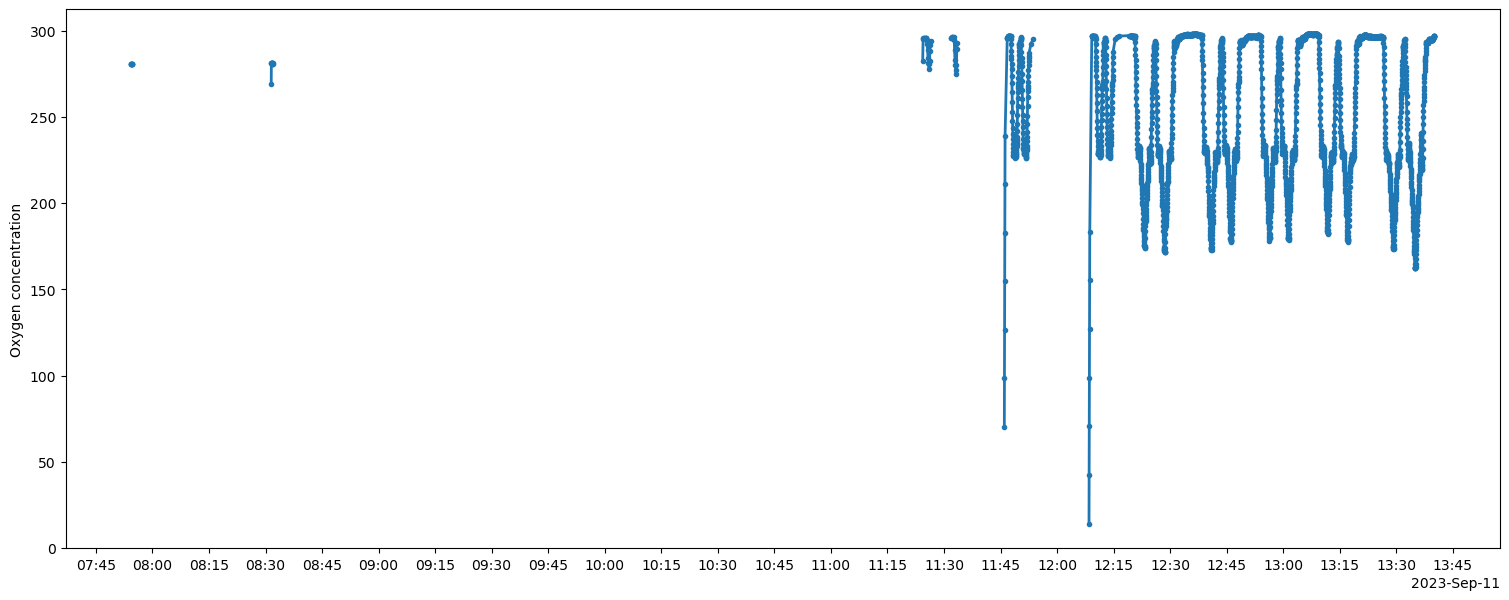

In [7]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 7)
#fig.set_dpi(100)
ax.plot(t, y, linewidth=2.0, marker='.')

#ylim = np.nanpercentile(x, [100, 0])
#ax.set_ylim(ylim)
#ax.set_xlim(x.min(), x.max())
ax.set_ylabel("Oxygen concentration")
#ax.set_xlabel("Date" if x_time else "Dives")
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
locator = mdates.AutoDateLocator(minticks=20, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

#plt.xticks(rotation=90) 
plt.show()

## QC tests

In [8]:
config = """
  contexts:
    - streams:
        oxygen_concentration:
          qartod:
              gross_range_test:
                suspect_span: [150, 400]
                fail_span: [0, 600]
              spike_test:
                suspect_threshold: 50
                fail_threshold: 100
              location_test:
                bbox: [17, 59, 25, 62]
              flat_line_test:
                tolerance: 1
                suspect_threshold: 3600
                fail_threshold: 86400
"""

c = Config(config)

In [9]:
c.stream_ids

['oxygen_concentration']

In [10]:
c.calls

[<Call stream_id=oxygen_concentration function=qartod.gross_range_test(suspect_span=[150, 400], fail_span=[0, 600])>,
 <Call stream_id=oxygen_concentration function=qartod.spike_test(suspect_threshold=50, fail_threshold=100)>,
 <Call stream_id=oxygen_concentration function=qartod.location_test(bbox=[17, 59, 25, 62])>,
 <Call stream_id=oxygen_concentration function=qartod.flat_line_test(tolerance=1, suspect_threshold=3600, fail_threshold=86400)>]

In [11]:
qc = XarrayStream(pyglider_timeseries, lon="longitude", lat="latitude", z="depth", time="time")

# Store as a list to run QC now
runner = list(qc.run(c))

results = collect_results(runner, how='list')

agg = CollectedResult(
    stream_id='',
    package='qartod',
    test='qc_rollup',
    function=aggregate,
    results=aggregate(results),
    tinp=qc.time(),
    data=data
)
results.append(agg)
results

[<CollectedResult stream_id=oxygen_concentration package=qartod test=gross_range_test>,
 <CollectedResult stream_id=oxygen_concentration package=qartod test=spike_test>,
 <CollectedResult stream_id=oxygen_concentration package=qartod test=location_test>,
 <CollectedResult stream_id=oxygen_concentration package=qartod test=flat_line_test>,
 <CollectedResult stream_id= package=qartod test=qc_rollup>]

In [12]:
def plot_ncresults(ncdata, var_name, results, title, test_name):
    """Helper method to plot QC results"""

    qc_test = next(r for r in results if r.stream_id == var_name and r.test == test_name)
    time = np.array(qc_test.tinp)
    obs = np.array(qc_test.data)
    results = qc_test.results

    qc_pass = np.ma.masked_where(results != 1, obs)
    num_pass = (results == 1).sum()
    qc_suspect = np.ma.masked_where(results != 3, obs)
    num_suspect = (results == 3).sum()
    qc_fail = np.ma.masked_where(results != 4, obs)
    num_fail = (results == 4).sum()
    qc_notrun = np.ma.masked_where(results != 2, obs)

    fig, ax = plt.subplots()

    fig.set_size_inches(18.5, 7)
    #fig.set_dpi(100)
    ax.plot(time, obs, linewidth=1.0, alpha=0.2, c="black")
    ax.scatter(time, qc_notrun, c="gray", alpha=0.2, s=20, label="QC not run", edgecolors='none')
    ax.scatter(time, qc_pass, c="green", alpha=0.5, s=40, label="QC pass", edgecolors='none')
    ax.scatter(time, qc_suspect, c="orange", alpha=0.7, s=40, label="QC suspect", edgecolors='none')
    ax.scatter(time, qc_fail, c="red", alpha=1.0, s=60, label="QC fail", edgecolors='none')

    ax.legend()
    ax.set_title(f"{test_name} : {title} : p/s/f= {num_pass}/{num_suspect}/{num_fail}")
    #ylim = np.nanpercentile(x, [100, 0])
    #ax.set_ylim(ylim)
    #ax.set_xlim(x.min(), x.max())
    ax.set_ylabel(title)
    #ax.set_xlabel("Date" if x_time else "Dives")
    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    #ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
    locator = mdates.AutoDateLocator(minticks=20, maxticks=30)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    #plt.xticks(rotation=90) 
    plt.show()

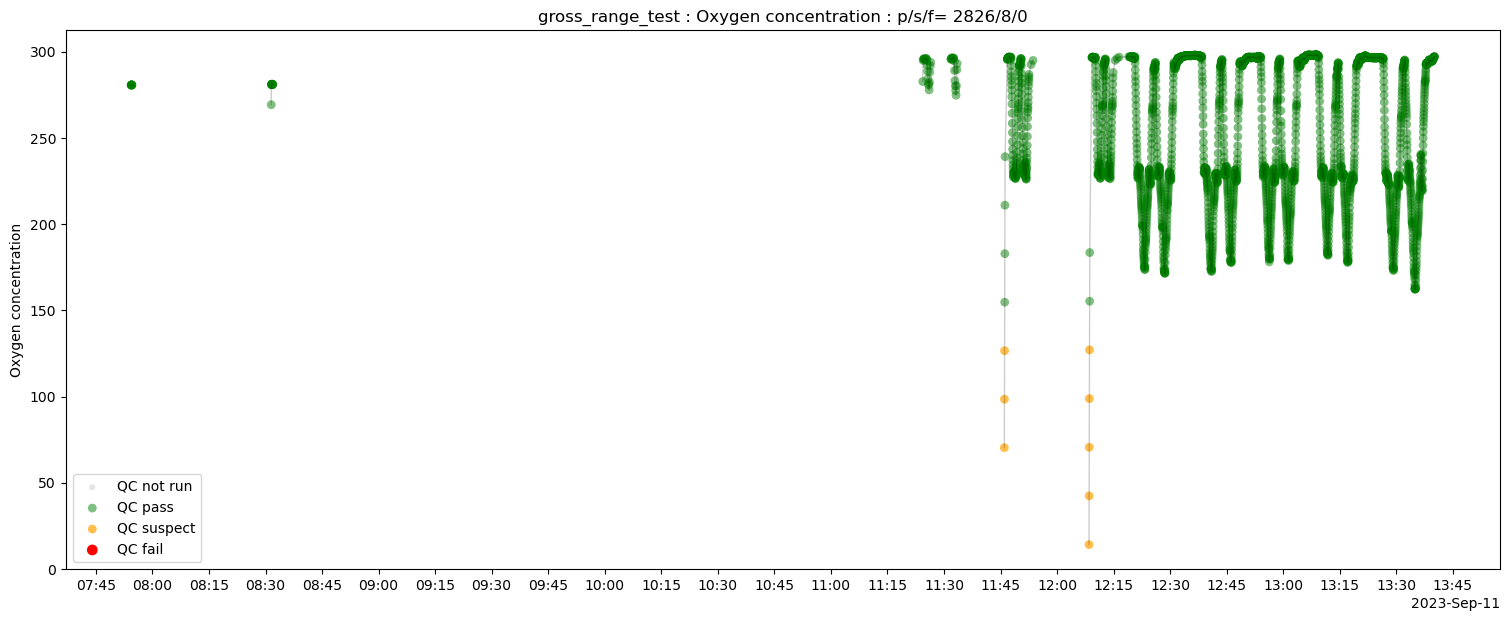

In [13]:
plot_ncresults(pyglider_timeseries, "oxygen_concentration", results, "Oxygen concentration", "gross_range_test")

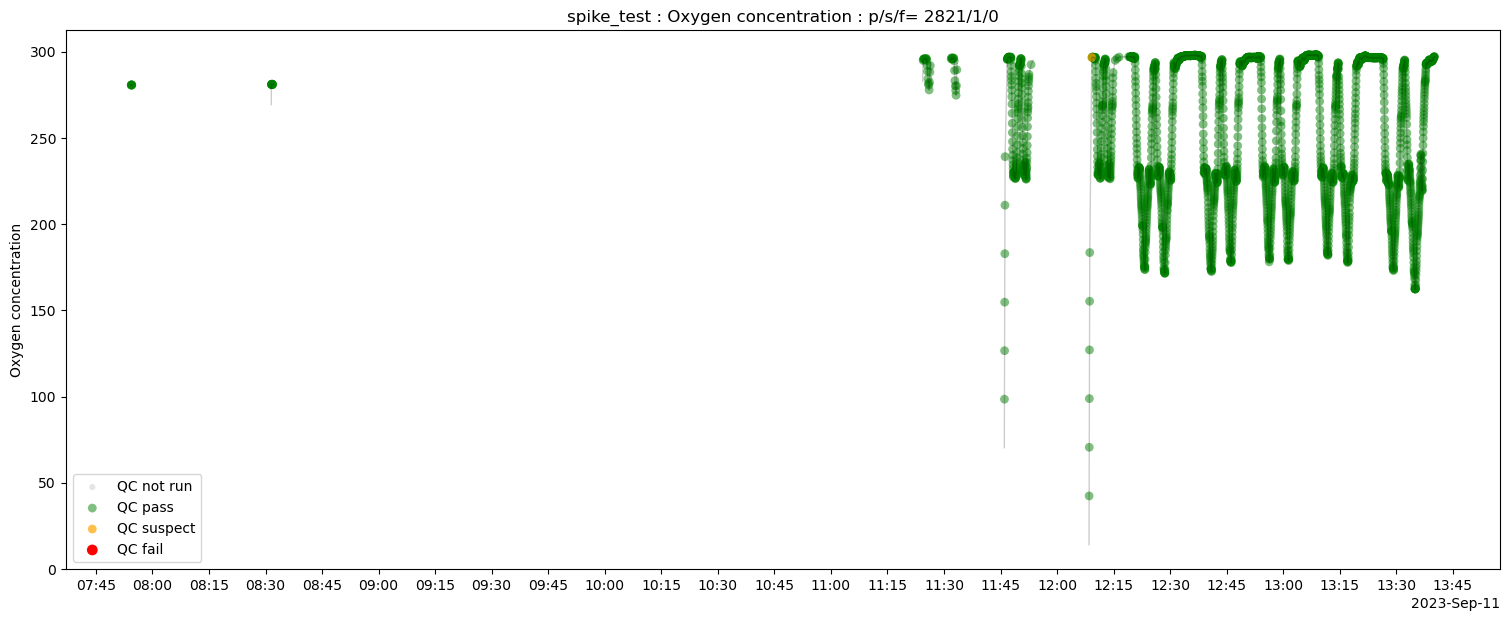

In [14]:
plot_ncresults(pyglider_timeseries, "oxygen_concentration", results, "Oxygen concentration", "spike_test")

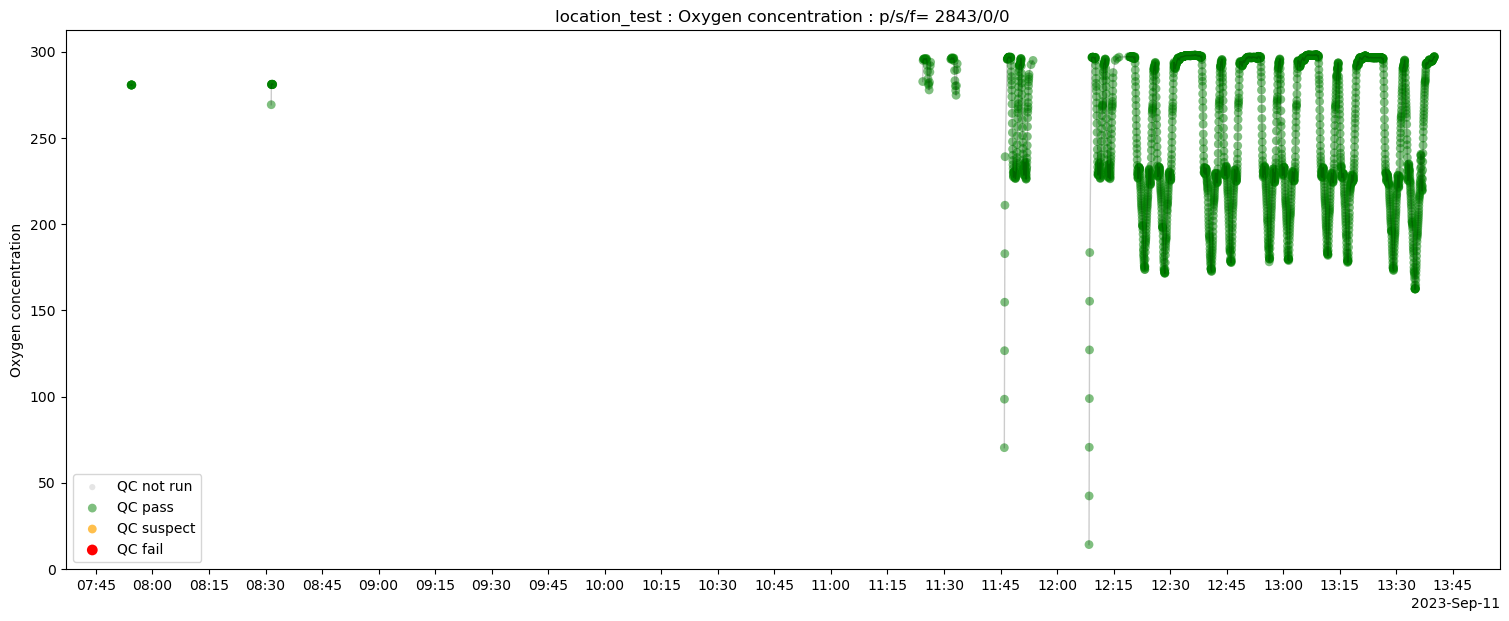

In [15]:
plot_ncresults(pyglider_timeseries, "oxygen_concentration", results, "Oxygen concentration", "location_test")

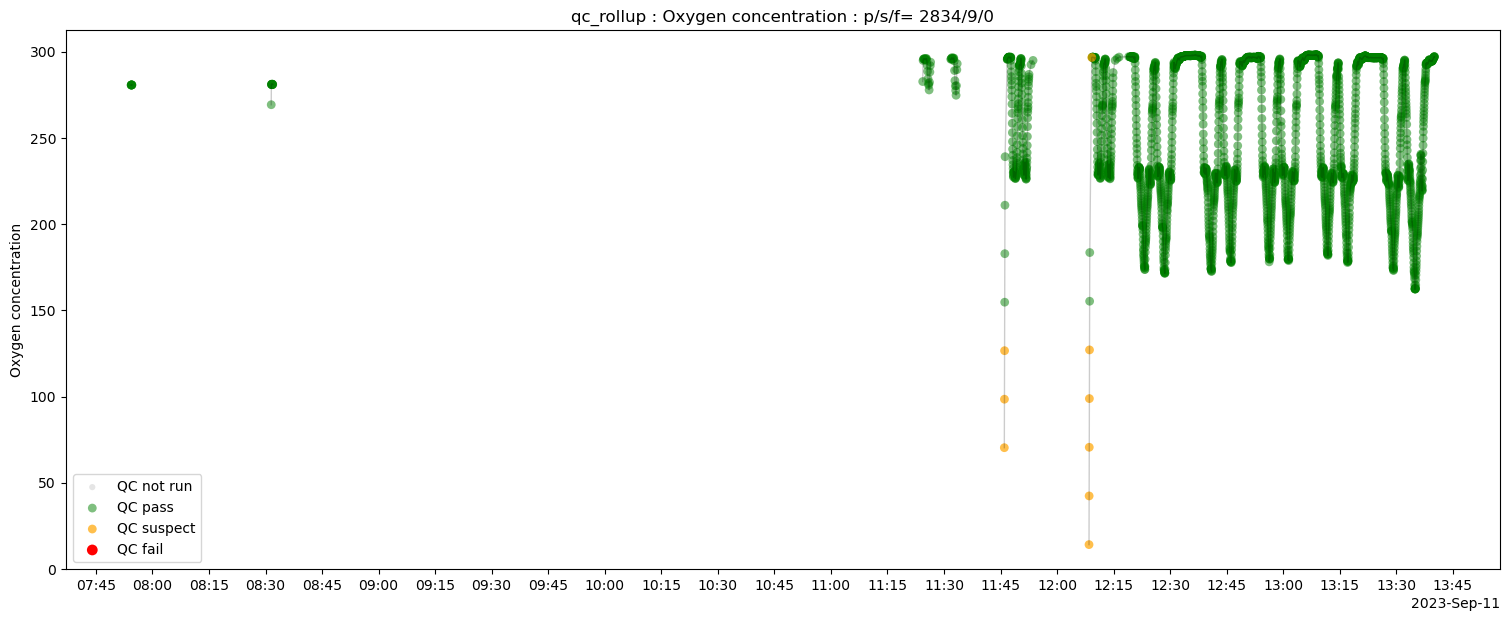

In [16]:
plot_ncresults(pyglider_timeseries, "", results, "Oxygen concentration", "qc_rollup")

In [17]:
agg_da = xr.DataArray(agg.results, {}, ('time',))
output_xds = pyglider_timeseries.assign(
    qartod_aggregate=agg_da
)

output_xds.qartod_aggregate

<xarray.DataArray 'qartod_aggregate' (time: 2844)>
array([9, 1, 1, ..., 1, 1, 1], dtype=uint8)
Coordinates:
  * time       (time) datetime64[ns] 2023-09-11T07:36:06 ... 2023-09-11T15:46:19
    latitude   (time) float64 nan 59.84 59.84 59.84 ... 59.86 59.86 59.86 59.86
    longitude  (time) float64 nan 23.25 23.25 23.25 ... 23.26 23.26 23.26 23.26
    depth      (time) float64 -0.1094 -0.1094 -0.1094 ... 0.01989 0.01989

In [18]:
clim_config = """
  contexts:
    - streams:
        oxygen_concentration:
          qartod:
              climatology_test:
                config: [
                {
                    "vspan": [150, 400],
                    "fspan": [0, 600],
                    "tspan": [0, 4],
                    "period": "dayofweek",
                    "zspan": [0, 100]
                },
                {
                    "vspan": [270, 290],
                    "fspan": [250, 300],
                    "tspan": [5, 6],
                    "period": "dayofweek",
                    "zspan": [0, 50]
                }]
"""

clim_c = Config(clim_config)

In [19]:
# qc = XarrayStream(pyglider_timeseries, lon="longitude", lat="latitude", z="depth", time="time")

# Store as a list to run QC now
clim_runner = list(qc.run(clim_c))

clim_results = collect_results(clim_runner, how='list')

agg = CollectedResult(
    stream_id='',
    package='qartod',
    test='qc_rollup',
    function=aggregate,
    results=aggregate(clim_results),
    tinp=qc.time(),
    data=data
)
clim_results.append(agg)
clim_results

[<CollectedResult stream_id=oxygen_concentration package=qartod test=climatology_test>,
 <CollectedResult stream_id= package=qartod test=qc_rollup>]

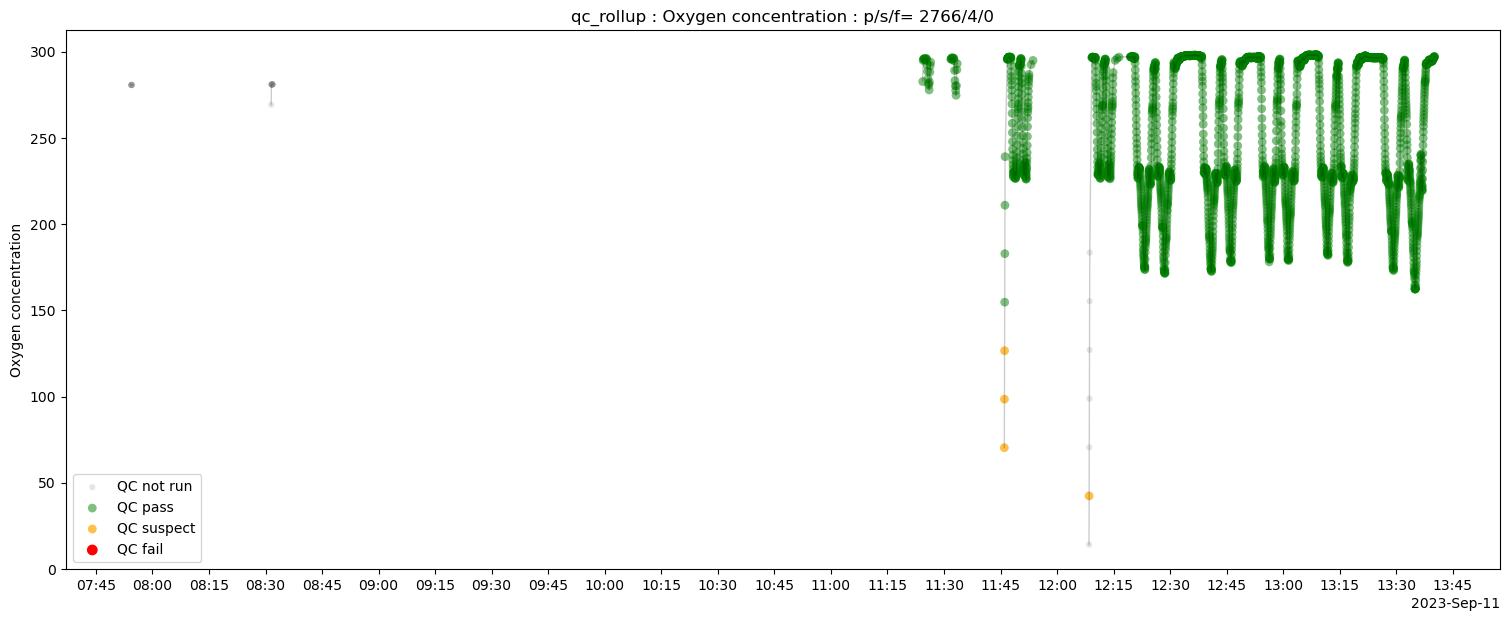

In [20]:
plot_ncresults(pyglider_timeseries, "", clim_results, "Oxygen concentration", "qc_rollup")

## Saving results

### Single variable config

In [21]:
# Assuming single variable config c,
# with aggregate results in agg
qc_variable_name = c.stream_ids[0] + "_qc"

agg_da = xr.DataArray(agg.results, {}, ('time',))

output_xds = pyglider_timeseries.copy()
output_xds[qc_variable_name] = agg_da
output_xds[qc_variable_name]

<xarray.DataArray 'oxygen_concentration_qc' (time: 2844)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Coordinates:
  * time       (time) datetime64[ns] 2023-09-11T07:36:06 ... 2023-09-11T15:46:19
    latitude   (time) float64 nan 59.84 59.84 59.84 ... 59.86 59.86 59.86 59.86
    longitude  (time) float64 nan 23.25 23.25 23.25 ... 23.26 23.26 23.26 23.26
    depth      (time) float64 -0.1094 -0.1094 -0.1094 ... 0.01989 0.01989

In [22]:
flags = getattr(inspect.getmodule(agg.function), 'FLAGS')
varflagnames = [ d for d in flags.__dict__ if not d.startswith('__') ]
varflagvalues = [ getattr(flags, d) for d in varflagnames ]

attrs = collections.OrderedDict([
        ('long_name', 'quality control flags for ' + pyglider_timeseries[c.stream_ids[0]].attrs['long_name']),
        ('standard_name', pyglider_timeseries[c.stream_ids[0]].attrs['standard_name'] + '_flag'),
        ('ioos_qc_module', agg.package),
        ('quality_control_conventions', 'IOOS QARTOD standard flags'),
        ('flag_values', np.byte(varflagvalues)),
        ('flag_meanings', ' '.join(varflagnames)),
        ('valid_min', np.byte(min(varflagvalues))),
        ('valid_max', np.byte(max(varflagvalues))),        
        ('comment', 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: ' + ioos_qc.__version__ + ' Using config: ' + str(c.calls))])
output_xds[qc_variable_name].attrs = attrs
output_xds[qc_variable_name]

<xarray.DataArray 'oxygen_concentration_qc' (time: 2844)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Coordinates:
  * time       (time) datetime64[ns] 2023-09-11T07:36:06 ... 2023-09-11T15:46:19
    latitude   (time) float64 nan 59.84 59.84 59.84 ... 59.86 59.86 59.86 59.86
    longitude  (time) float64 nan 23.25 23.25 23.25 ... 23.26 23.26 23.26 23.26
    depth      (time) float64 -0.1094 -0.1094 -0.1094 ... 0.01989 0.01989
Attributes:
    long_name:                    quality control flags for oxygen concentration
    standard_name:                mole_concentration_of_dissolved_molecular_o...
    ioos_qc_module:               qartod
    quality_control_conventions:  IOOS QARTOD standard flags
    flag_values:                  [1 2 3 4 9]
    flag_meanings:                GOOD UNKNOWN SUSPECT FAIL MISSING
    valid_min:                    1
    valid_max:                    9
    comment:                      Quality control flags from IOOS QC QARTOD h...

In [57]:
output_xds.attrs["processing_level"] += ". Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: " + ioos_qc.__version__
output_xds.to_netcdf("out.nc")

### Multi-variable config

In [23]:
config = """
  contexts:
    - streams:
        oxygen_concentration:
          qartod:
              gross_range_test:
                suspect_span: [150, 400]
                fail_span: [0, 600]
              spike_test:
                suspect_threshold: 50
                fail_threshold: 100
              location_test:
                bbox: [17, 59, 25, 62]
              flat_line_test:
                tolerance: 1
                suspect_threshold: 3600
                fail_threshold: 86400
        temperature:
          qartod:
              gross_range_test:
                suspect_span: [2, 15]
                fail_span: [1, 16]
              spike_test:
                suspect_threshold: 5
                fail_threshold: 10
              location_test:
                bbox: [17, 59, 25, 62]
              flat_line_test:
                tolerance: 0.1
                suspect_threshold: 3600
                fail_threshold: 86400
"""

c = Config(config)

In [24]:
qc = XarrayStream(pyglider_timeseries, lon="longitude", lat="latitude", z="depth", time="time")

# Store as a list to run QC now
runner = list(qc.run(c))

results = collect_results(runner, how='list')

In [27]:
output_xds = pyglider_timeseries.copy()

for stream_id in c.stream_ids:

    stream_results = [result for result in results if result.stream_id == stream_id]
    
    agg = CollectedResult(
              stream_id=stream_id,
              package='qartod',
              test='qc_rollup',
              function=aggregate,
              results=aggregate(results),
              tinp=qc.time(),
              data=pyglider_timeseries[stream_id]
          )
    results.append(agg) # optional, for further use of results

    qc_variable_name = stream_id + "_qc"

    agg_da = xr.DataArray(agg.results, {}, ('time',))

    output_xds[qc_variable_name] = agg_da

    flags = getattr(inspect.getmodule(agg.function), 'FLAGS')
    varflagnames = [ d for d in flags.__dict__ if not d.startswith('__') ]
    varflagvalues = [ getattr(flags, d) for d in varflagnames ]

    attrs = collections.OrderedDict([
            ('long_name', 'quality control flags for ' + pyglider_timeseries[stream_id].attrs['long_name']),
            ('standard_name', pyglider_timeseries[stream_id].attrs['standard_name'] + '_flag'),
            ('ioos_qc_module', agg.package),
            ('quality_control_conventions', 'IOOS QARTOD standard flags'),
            ('flag_values', np.byte(varflagvalues)),
            ('flag_meanings', ' '.join(varflagnames)),
            ('valid_min', np.byte(min(varflagvalues))),
            ('valid_max', np.byte(max(varflagvalues))),        
            ('comment', 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: ' + 
             ioos_qc.__version__ + ' Using config: ' + str(c.calls_by_stream_id(stream_id)))])
    output_xds[qc_variable_name].attrs = attrs
    
output_xds.attrs["processing_level"] += ". Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: " + ioos_qc.__version__
output_xds

<xarray.Dataset>
Dimensions:                  (time: 2844)
Coordinates:
  * time                     (time) datetime64[ns] 2023-09-11T07:36:06 ... 20...
    latitude                 (time) float64 nan 59.84 59.84 ... 59.86 59.86
    longitude                (time) float64 nan 23.25 23.25 ... 23.26 23.26
    depth                    (time) float64 -0.1094 -0.1094 ... 0.01989 0.01989
Data variables: (12/28)
    heading                  (time) float64 ...
    pitch                    (time) float64 ...
    roll                     (time) float64 ...
    waypoint_latitude        (time) float64 ...
    waypoint_longitude       (time) float64 ...
    conductivity             (time) float64 ...
    ...                       ...
    density                  (time) float64 ...
    potential_temperature    (time) float64 ...
    profile_index            (time) float64 ...
    profile_direction        (time) float64 ...
    oxygen_concentration_qc  (time) uint8 9 1 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 1
    temperature_qc           (time) uint8 9 1 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 1
Attributes: (12/61)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           TVAR2023_2_Koskelo
    cdm_data_type:             Trajectory
    comment:                   Tvärminne, Gulf of Finland deployment Sep 2023.
    contributor_name:          Kimmo Tikka,
    ...                        ...
    summary:                   Manufacturer test in Saanich Inlet.
    time_coverage_end:         2023-09-11T15:46:19.000000000
    time_coverage_start:       2023-09-11T07:36:06.000000000
    title:                     koskelo1052-20230911T0736
    transmission_system:       IRRIDIUM
    wmo_id:                    6801691

In [28]:
output_xds["temperature_qc"]

<xarray.DataArray 'temperature_qc' (time: 2844)>
array([9, 1, 4, ..., 4, 4, 1], dtype=uint8)
Coordinates:
  * time       (time) datetime64[ns] 2023-09-11T07:36:06 ... 2023-09-11T15:46:19
    latitude   (time) float64 nan 59.84 59.84 59.84 ... 59.86 59.86 59.86 59.86
    longitude  (time) float64 nan 23.25 23.25 23.25 ... 23.26 23.26 23.26 23.26
    depth      (time) float64 -0.1094 -0.1094 -0.1094 ... 0.01989 0.01989
Attributes:
    long_name:                    quality control flags for water temperature
    standard_name:                sea_water_temperature_flag
    ioos_qc_module:               qartod
    quality_control_conventions:  IOOS QARTOD standard flags
    flag_values:                  [1 2 3 4 9]
    flag_meanings:                GOOD UNKNOWN SUSPECT FAIL MISSING
    valid_min:                    1
    valid_max:                    9
    comment:                      Quality control flags from IOOS QC QARTOD h...

In [9]:
# xr.backends.file_manager.FILE_CACHE.clear() # Supposed to help with netCDFs being unable to be changed after reading them in

In [10]:
output_xds.to_netcdf("out.nc")
output_xds.close() # Supposed to help with netCDFs being unable to be changed after reading them in

In [ ]:
test_output = xr.open_dataset("out.nc")
test_output.close() # Supposed to help with netCDFs being unable to be changed after reading them in
display(test_output) # Using display explicitly supposed to help with netCDFs being unable to be changed after reading them in

In [ ]:
display(test_output["oxygen_concentration_qc"]) # Using display explicitly supposed to help with netCDFs being unable to be changed after reading them in

## VOTO model

In [29]:
voto_config = """
  contexts:
    - streams:
        conductivity:
            qartod:
                gross_range_test:
                    suspect_span: [0.6, 4.2]
                    fail_span: [0.3, 4.5]
                location_test:
                    box: [16, 58, 30, 66]
        temperature:
            qartod:
                gross_range_test:
                    suspect_span: [0, 30]
                    fail_span: [-2.5, 40]
                spike_test:
                    suspect_threshold: 2
                    fail_threshold: 6
                location_test:
                    bbox: [16, 58, 30, 66]
        oxygen_concentration:
            qartod:
                gross_range_test:
                    suspect_span: [0, 350]
                    fail_span: [-0, 500]
                spike_test:
                    suspect_threshold: 10
                    fail_threshold: 50
                location_test:
                    bbox: [16, 58, 30, 66]
        chlorophyll:
            qartod:
                gross_range_test:
                    suspect_span: [0, 15]
                    fail_span: [-1, 20]
                spike_test:
                    suspect_threshold: 1
                    fail_threshold: 5
                location_test:
                    bbox: [16, 58, 30, 66]
"""
voto_salinity_config = """
  contexts:
    - streams:
        conductivity:
            qartod:
                gross_range_test:
                    suspect_span: [0.6, 4.2]
                    fail_span: [0.3, 4.5]
        salinity:
            qartod:
                gross_range_test:
                    suspect_span: [5, 38]
                    fail_span: [2, 41]
                spike_test:
                    suspect_threshold: 0.3
                    fail_threshold: 0.9
                location_test:
                    bbox: [16, 58, 30, 66]
"""
voto_density_config = """
  contexts:
    - streams:
        temperature:
            qartod:
                gross_range_test:
                    suspect_span: [0, 30]
                    fail_span: [-2.5, 40]
                spike_test:
                    suspect_threshold: 2
                    fail_threshold: 6
                location_test:
                    bbox: [16, 58, 30, 66]
        conductivity:
            qartod:
                gross_range_test:
                    suspect_span: [0.6, 4.2]
                    fail_span: [0.3, 4.5]
        salinity:
            qartod:
                gross_range_test:
                    suspect_span: [5, 38]
                    fail_span: [2, 41]
                spike_test:
                    suspect_threshold: 0.3
                    fail_threshold: 0.9
                location_test:
                    bbox: [16, 58, 30, 66]
"""
# voto_density_config used for density, potential density and potential temperature

eurogoos_reference = (" Threshold values from EuroGOOS DATA-MEQ Working Group (2010)"
                      " Recommendations for in-situ data Near Real Time Quality Control [Version 1.2]."
                      " EuroGOOS, 23pp. DOI http://dx.doi.org/10.25607/OBP-214.")

In [31]:
pyglider_timeseries = xr.open_dataset(datadir+"TVAR20232.nc")
output_xds = pyglider_timeseries.copy()

In [32]:
c = Config(voto_config)

qc = XarrayStream(pyglider_timeseries, lon="longitude", lat="latitude", z="depth", time="time")

# Store as a list to run QC now
runner = list(qc.run(c))

results = collect_results(runner, how='list')

for stream_id in c.stream_ids:

    stream_results = [result for result in results if result.stream_id == stream_id]
    
    agg = CollectedResult(
              stream_id=stream_id,
              package='qartod',
              test='qc_rollup',
              function=aggregate,
              results=aggregate(stream_results),
              tinp=qc.time(),
              data=pyglider_timeseries[stream_id]
          )
    
    results.append(agg) # optional, for further use of results

    qc_variable_name = stream_id + "_qc"

    output_xds[qc_variable_name] = xr.DataArray(agg.results, {}, ('time',))

    flags = getattr(inspect.getmodule(agg.function), 'FLAGS')
    varflagnames = [ d for d in flags.__dict__ if not d.startswith('__') ]
    varflagvalues = [ getattr(flags, d) for d in varflagnames ]

    attrs = collections.OrderedDict([
            ('long_name', 'quality control flags for ' + pyglider_timeseries[stream_id].attrs['long_name']),
            ('standard_name', pyglider_timeseries[stream_id].attrs['standard_name'] + '_flag'),
            ('ioos_qc_module', agg.package),
            ('quality_control_conventions', 'IOOS QARTOD standard flags'),
            ('flag_values', np.byte(varflagvalues)),
            ('flag_meanings', ' '.join(varflagnames)),
            ('valid_min', np.byte(min(varflagvalues))),
            ('valid_max', np.byte(max(varflagvalues))),        
            ('comment', 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: ' + 
             ioos_qc.__version__ + ' Using config: ' + str(c.calls_by_stream_id(stream_id)) + '.')])
    
    output_xds[qc_variable_name].attrs = attrs

output_xds["temperature_qc"].attrs["comment"] += eurogoos_reference
output_xds["conductivity_qc"].attrs["comment"] += eurogoos_reference

In [33]:
c = Config(voto_salinity_config)

# Store as a list to run QC now
runner = list(qc.run(c))

salinity_results = collect_results(runner, how='list')

agg = CollectedResult(
            stream_id='',
            package='qartod',
            test='qc_rollup',
            function=aggregate,
            results=aggregate(salinity_results),
            tinp=qc.time(),
            data=pyglider_timeseries
        )

salinity_results.append(agg) # optional, for further use of results

qc_variable_name = "salinity_qc"

output_xds[qc_variable_name] = xr.DataArray(agg.results, {}, ('time',))

flags = getattr(inspect.getmodule(agg.function), 'FLAGS')
varflagnames = [ d for d in flags.__dict__ if not d.startswith('__') ]
varflagvalues = [ getattr(flags, d) for d in varflagnames ]

attrs = collections.OrderedDict([
        ('long_name', 'quality control flags for ' + pyglider_timeseries["salinity"].attrs['long_name']),
        ('standard_name', pyglider_timeseries["salinity"].attrs['long_name'] + "_flag"),
        ('ioos_qc_module', agg.package),
        ('quality_control_conventions', 'IOOS QARTOD standard flags'),
        ('flag_values', np.byte(varflagvalues)),
        ('flag_meanings', ' '.join(varflagnames)),
        ('valid_min', np.byte(min(varflagvalues))),
        ('valid_max', np.byte(max(varflagvalues))),        
        ('comment', 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: ' + 
         ioos_qc.__version__ + ' Using config: ' + str(c.calls)  + '.' +
         eurogoos_reference)])

output_xds[qc_variable_name].attrs = attrs

In [34]:
c = Config(voto_density_config)

# Store as a list to run QC now
runner = list(qc.run(c))

density_results = collect_results(runner, how='list')

for qc_variable_name in ["density_qc", "potential_density_qc", "potential_temperature_qc"]:

    agg = CollectedResult(
              stream_id='',
              package='qartod',
              test='qc_rollup',
              function=aggregate,
              results=aggregate(density_results),
              tinp=qc.time(),
              data=pyglider_timeseries
          )
    
    density_results.append(agg) # optional, for further use of results

    output_xds[qc_variable_name] = xr.DataArray(agg.results, {}, ('time',))

    flags = getattr(inspect.getmodule(agg.function), 'FLAGS')
    varflagnames = [ d for d in flags.__dict__ if not d.startswith('__') ]
    varflagvalues = [ getattr(flags, d) for d in varflagnames ]

    attrs = collections.OrderedDict([
            ('long_name', 'quality control flags for water ' + qc_variable_name.replace("_"," ").replace("qc","")),
            ('standard_name', 'sea_water_' + qc_variable_name.replace("qc","flag")),
            ('ioos_qc_module', agg.package),
            ('quality_control_conventions', 'IOOS QARTOD standard flags'),
            ('flag_values', np.byte(varflagvalues)),
            ('flag_meanings', ' '.join(varflagnames)),
            ('valid_min', np.byte(min(varflagvalues))),
            ('valid_max', np.byte(max(varflagvalues))),        
            ('comment', 'Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: ' + 
             ioos_qc.__version__ + ' Using config: ' + str(c.calls)  + '.' +
             eurogoos_reference)])
    
    output_xds[qc_variable_name].attrs = attrs

In [ ]:
""" This dataset doesn't have cdom like VOTO's dataset that's mimicked here does
attrs = collections.OrderedDict([
        ('long_name', 'quality control flags for ' + pyglider_timeseries["cdom"].attrs['long_name']),
        ('standard_name', pyglider_timeseries["cdom"].attrs['standard_name'] + '_flag'), # this dataset lacks standard name for cdom
        ('quality_control_conventions', 'IOOS QARTOD standard flags'),
        ('flag_values', np.byte(varflagvalues)),
        ('flag_meanings', ' '.join(varflagnames)),
        ('valid_min', np.byte(min(varflagvalues))),
        ('valid_max', np.byte(max(varflagvalues))),        
        ('comment', 'Minimum QC value set to 4. IOOS_QC: no automated QC applied')])

output_xds["cdom_qc"] = output_xds["temperature_qc"]*0+4
output_xds["cdom_qc"].attrs = attrs
 """

In [38]:
output_xds.attrs["processing_level"] += ". Quality control flags from IOOS QC QARTOD https://github.com/ioos/ioos_qc Version: " + ioos_qc.__version__
output_xds.to_netcdf("out.nc")

## Testing and Development

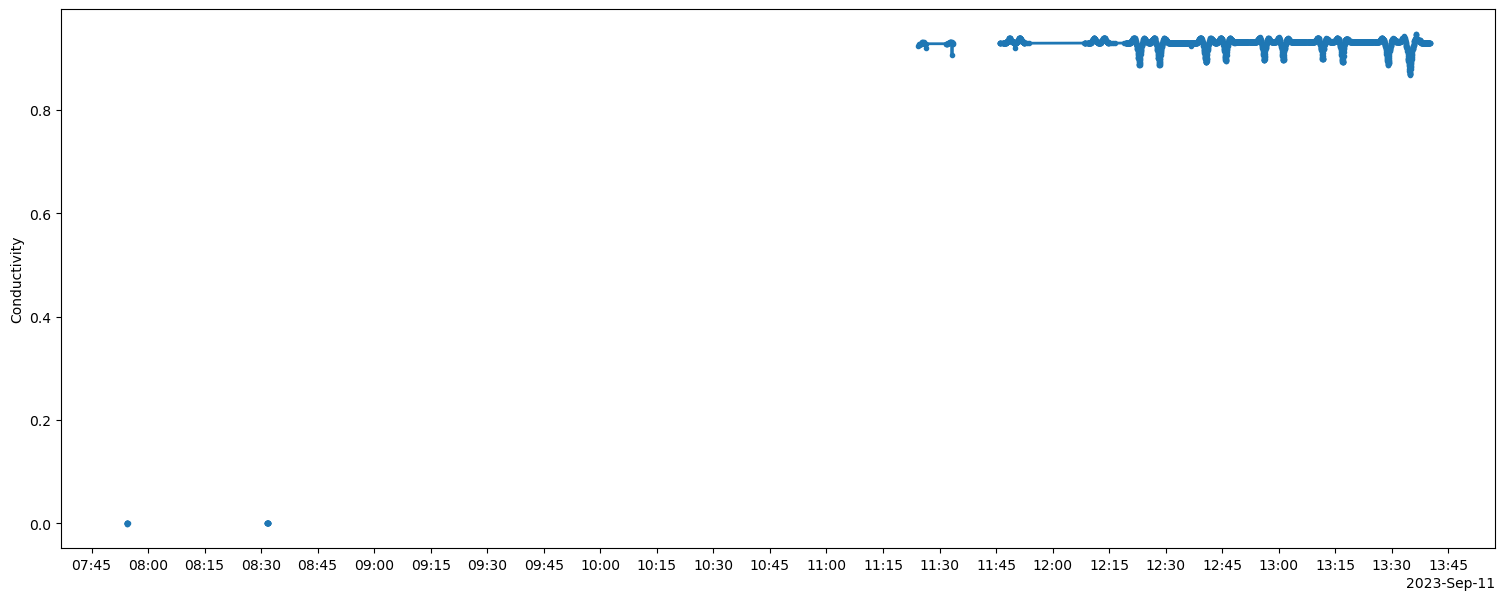

In [39]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 7)
ax.plot(pyglider_timeseries["time"].values, pyglider_timeseries["conductivity"].values, linewidth=2.0, marker='.')

ax.set_ylabel("Conductivity")

locator = mdates.AutoDateLocator(minticks=20, maxticks=30)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

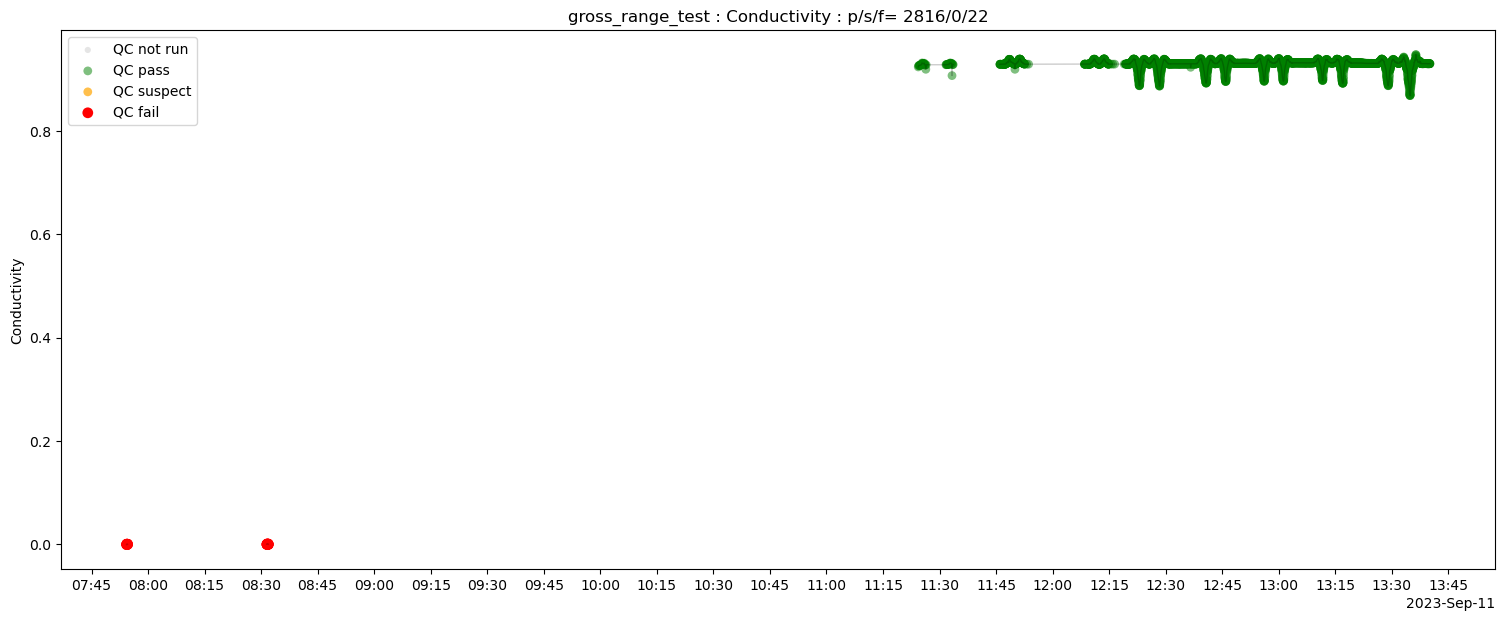

In [40]:
plot_ncresults(pyglider_timeseries, "conductivity", results, "Conductivity", "gross_range_test")